# Table of content
* [The assignment](#Introduction)
* [Loading the data](#LoadingTheData)
* [Exploratory data analysis](#ExploratoryDataAnalysis)
    * [How many bank entries do companies have?](#HowManyBankEntries)
    * [How many accounts do companies have?](#HowManyAccounts)
    * [How many bank entries are there per account?](#HowManyBankEntriesPerAccount)
    * [Looking into a single company in more detail](#SingleCompanyExploratory)
* [Building the baseline classifier](#BuildingTheBaselineClassifier) (Part 1)
    * [Testing the baseline classifier](#TestingTheBaselineClassifier)
* [Taking advantage of the data across different companies](#TheSecondPart) (Part 2)

# The assignment<a id='Introduction'></a>
This is my solution to the hiring assignment posed to candidates applying for a Data Science position at e-conomic. The assignment is descibed in detail in [here](https://github.com/e-conomic/hiring-assigments/tree/master/autosuggest/bankrec-assignment)

In short the assignment is to build a classifier that that can predict which account a given bank entry should be filed under. The assignment is divided into two parts. In the first the candidate is asked to build and test a classifier __for each__ company. In the second part the candidate is asked to reflect on how one could build a classifier that works __for all__ companies. This would greatly increase the amount of training data and (perhaps) simply the process of classifying the bank entries.

# The data
The dataset consist of expenses from 100 random companies. For each company we provide all expenses that was booked in e-conomic (737017 bank entries in total). 

Description of each column in the dataset:
* **CompanyId**: The identifyer of the company to help you slice and dice the data in the right way.
* **BankEntryDate (feature)**: The date of the financial transaction.
* **BankEntryText (feature)**: The text following along with the financial transaction. This is typically machine generated, but in case of manual transactions they may be manually written by a human.
* **BankEntryAmount (feature)**: The amount of the financial transaction. Expenses are negative, earnings are positive.
* **AccountNumber (target)**: The account number. The uniquely identifies an account, and can therefore be used as the target variable / the class that we want to predict.
* **AccountName**: The name of the account.
* **AccountTypeName**: The type of the account.

# Summary of main finding
* The data contains 100 companies, and 737017 bank entries. Of these **90% (667021/737017) are from a single company!** It is much more common for a company to have close to 1000 bank entries
* Many of the companies have **fewer than 10 bank entries per account**, on average.

# Loading and inspecting the data<a id='LoadingTheData'></a>

In [550]:
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

data = pd.read_csv('bank_expenses_obfuscated.csv')

print(data.shape)

(737017, 8)


We have 737017 entries.

Let's look at the first 5 rows of the dataframe.

In [551]:
print(data[0:5])

   Unnamed: 0    CompanyId BankEntryDate  \
0           0  int:a055470    2016-02-29   
1           1  int:a055470    2016-02-29   
2           2  int:a055470    2016-02-29   
3           3  int:a055470    2016-02-29   
4           4  int:a055470    2016-02-29   

                                     BankEntryText BankEntryAmount  \
0                          str:6cd08e4 int:49fed34         > -1000   
1                          str:6cd08e4 int:49fed34         > -1000   
2                                      str:38248d2          > -100   
3                                      str:38248d2          > -100   
4  str:c704d91 str:1b0ad3b str:2598b78 str:070dddb        > -10000   

   AccountName  AccountNumber  AccountTypeName  
0  str:1e82557           9900          Balance  
1  str:9ce853c           3115  Profit and Loss  
2  str:a9f0788           2240  Profit and Loss  
3  str:1e82557           9900          Balance  
4  str:a67d2b5           2270  Profit and Loss  


# Exploratory data analysis<a id='ExploratoryDataAnalysis'></a>
## How many bank entries do the companies have? <a id='HowManyBankEntries'></a>

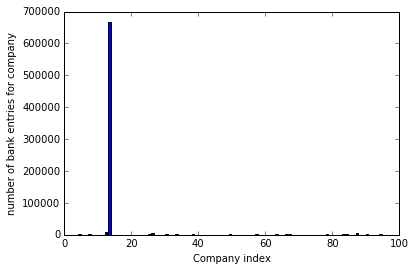

In [552]:
companies = data['CompanyId'].unique()
companies.shape

kk = 0
numBankEntries = np.zeros((100,1))
for company in companies:
    numBankEntriesTemp = data[data.CompanyId==company].count()[0]
    numBankEntries[kk] = numBankEntriesTemp
    kk += 1
    
plt.bar(range(0,100),numBankEntries)
plt.xlabel('Company index')
plt.ylabel('number of bank entries for company')

So by far the majority of bank entries are located with just a single company!

In [553]:
numBankEntries[13]

array([ 667021.])

It would be tempting to contine the analysis using this company, but it would be very representative of the average company.

Looking at 80 of the companies we see that it is much more common to have close to, or below 1000 entries. 

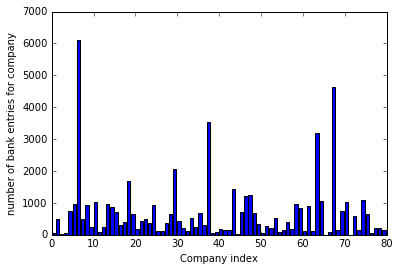

In [554]:
plt.bar(range(0,80),numBankEntries[20:100])
plt.xlabel('Company index')
plt.ylabel('number of bank entries for company')

In [555]:
for index in range(0,10):
    print(companies[index],numBankEntries[index])

('int:a055470', array([ 292.]))
('int:d113597', array([ 749.]))
('int:7cb070e', array([ 808.]))
('int:4688107', array([ 718.]))
('int:fadeb6a', array([ 1267.]))
('int:70a517b', array([ 413.]))
('int:0803ca7', array([ 72.]))
('int:c83caff', array([ 1709.]))
('int:d5ab817', array([ 366.]))
('int:3b4d93c', array([ 104.]))


## How many accounts do the companies have? <a id='HowManyAccounts'></a>

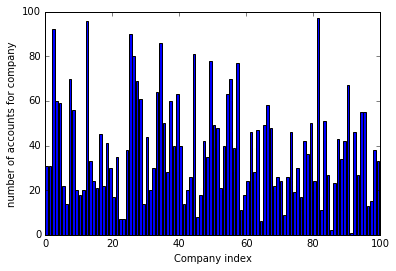

In [556]:
kk = 0
numAccounts = np.zeros((100,1))
for company in companies:
    company_data = data[data.CompanyId==company]
    numAccountsUnique = company_data['AccountNumber'].unique()
    numAccounts[kk] = numAccountsUnique.shape[0]
    kk += 1
    
plt.bar(range(0,100),numAccounts)
plt.xlabel('Company index')
plt.ylabel('number of accounts for company')

The number of accounts the companies have varies greatly.

A histogram of the number of accounts makes this point more clearly.

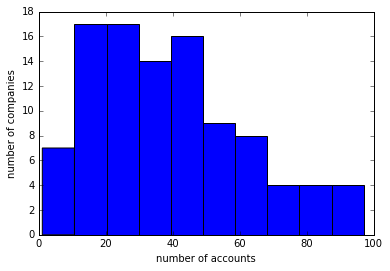

In [582]:
plt.hist(numAccounts)
plt.xlabel('number of accounts')
plt.ylabel('number of companies')

Most companies have between 10 and 50 accounts. 

## Do companies with more bank entries also have more accounts?<a id='HowManyBankEntriesPerAccount'></a>


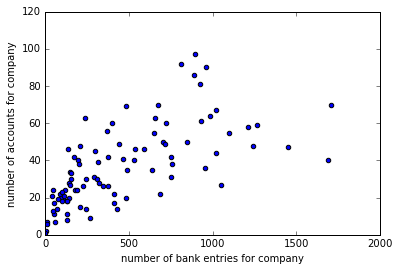

In [557]:
plt.scatter(numBankEntries,numAccounts)
plt.axis([0, 2000, 0, 120])
plt.xlabel('number of bank entries for company')
plt.ylabel('number of accounts for company')

[0, 100, 0, 20]

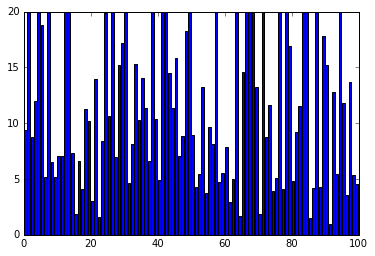

In [558]:
bankEntriesPerAccount = numBankEntries/numAccounts
plt.bar(range(0,100),bankEntriesPerAccount)
plt.axis([0, 100, 0, 20])

So it seems that quite a lot of the companies have fewer than 10 bank entries per account. This means that if we want to train a classifier per account per company, we had better use a classification model that does not need a lot of data to give good results.

# Looking at a single company in more detail<a id='SingleCompanyExploratory'></a>
I will start by looking a the data for a single company. We will use **int:7cb070e**. First i selevt just the data from ths company.

In [559]:
company_df = data[data.CompanyId=='int:7cb070e']
company_df[0:5]

,Unnamed: 0,CompanyId,BankEntryDate,BankEntryText,BankEntryAmount,AccountName,AccountNumber,AccountTypeName
1041,0,int:7cb070e,2016-06-29,str:0910abd str:325c669 str:acbadfb int:e14c8e7,> -10000,str:40b14b3,1310,Profit and Loss
1042,1,int:7cb070e,2016-06-29,str:4a5eaad str:640555d,> -10000,str:3a4a6a4,1321,Profit and Loss
1043,2,int:7cb070e,2016-06-28,str:1977f5c,> -100,str:d5770eb,2350,Profit and Loss
1044,3,int:7cb070e,2016-06-28,str:6086f71,> -10000,str:40b14b3,1310,Profit and Loss
1045,4,int:7cb070e,2016-06-27,str:2147693,> -10000,str:40b14b3,1310,Profit and Loss


In [560]:
company_df.shape

(808, 8)

So the company has a total of **808 bank entries**.

How many accounts does the company have?

In [561]:
AccountNumber = company_df['AccountNumber'].unique()
numUniqueAccounts = AccountNumber.shape[0]
print(numUniqueAccounts)

92


The company has **92 accounts**

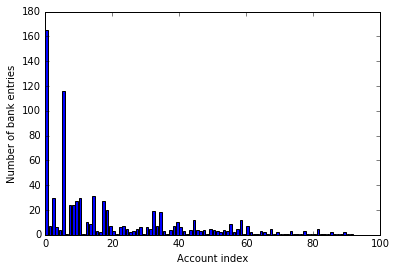

In [562]:
bakEntriesPerAccount = np.zeros(AccountNumber.shape)
kk=0
for item in AccountNumber:
    temp_bakEntriesPerAccount = company_df[company_df.AccountNumber==item].count()[0]
    bakEntriesPerAccount[kk] = temp_bakEntriesPerAccount
    kk += 1

plt.bar(range(0,AccountNumber.shape[0]),popularity,)
plt.xlabel('Account index')
plt.ylabel('Number of bank entries')

So this is the popularity of each of each Account. The index on the x-axis corresponds to the indexing of AccountNumber, that is:

In [563]:
AccountNumber

array([1310, 1321, 2350, 3600, 5680, 1031, 2355, 6920, 3620, 1033, 1032,
       6903, 3411, 3675, 1910, 3604, 1362, 3010, 3420, 6921, 3663, 3662,
       1312, 6917, 2360, 1320, 3020, 1342, 2222, 6760, 1370, 3030, 6570,
       1322, 3621, 3430, 3060, 1341, 1343, 3040, 3640, 3260, 3610, 1351,
       3330, 1332, 1333, 1331, 5660, 3628, 2754, 2800, 1352, 2213, 6835,
       1330, 1353, 3664, 9900, 3250, 2241, 3050, 1510, 1010, 1323, 2770,
       4410, 4430, 3648, 6901, 4640, 3051, 3780, 5313, 1385, 4310, 3240,
       2211, 3450, 6560, 2320, 1340, 6765, 2390, 5665, 3617, 1300, 4440,
       5222, 1363, 2801, 6136])

The exact numbers are the following:

In [564]:
bakEntriesPerAccount

array([ 165.,    7.,   30.,    6.,    4.,  116.,    1.,   24.,   24.,
         27.,   30.,    1.,   10.,    9.,   31.,    3.,    2.,   27.,
         20.,    7.,    3.,    1.,    6.,    7.,    5.,    2.,    3.,
          5.,    6.,    1.,    6.,    5.,   19.,    7.,   18.,    3.,
          1.,    4.,    7.,   10.,    6.,    3.,    1.,    4.,   12.,
          4.,    3.,    4.,    1.,    5.,    4.,    3.,    2.,    4.,
          3.,    9.,    2.,    5.,   12.,    1.,    7.,    2.,    1.,
          1.,    3.,    2.,    1.,    5.,    1.,    2.,    1.,    1.,
          1.,    3.,    1.,    1.,    1.,    3.,    1.,    1.,    1.,
          5.,    1.,    1.,    1.,    2.,    1.,    1.,    1.,    2.,
          1.,    1.])

In conclusion: We can expect the majority of the of the transactions to fall within a small number (~5 our of 31) of the accounts. This is usefull to know when building a classifier. But it does not help us actually classify the transactions.

# Building a baseline classifier<a id='BuildingTheBaselineClassifier'></a>
The exploratory analysis presented above suggests that a reasonable baseline would be to establish the frequency of each **speciic** bank entry going into a spefic account. That is, I want to calculate the following: Given a **BankEntryText** what is the probability that it is classified as **AccountNumber**. When I have **P** for each **AccountNumber**, I can sort by **P** and use that as my classifier. 

It will not be perfect and it only uses a single feature, but it is a good baseline. Any classification system I build should at least be able to beat this raw probability appraoch.

For this I will continue to use the company with Conpanyid **int:a055470**

## Finding the unique bank entry texts
First I find all the unique **BankEntryText** for the Company

In [565]:
BankEntryText = company_df['BankEntryText'].unique()
numUniqueBankEntries = BankEntryText.shape[0]

Since the company has a total of **808 bank entries**, finding that **320 of them are unique** is not great for the probabalistic approach. 

## Etablishing the probabilities
I want to use the following abstraction: I will create a matrice containing the unique bank entries and the bank accounts. That is, it will be a matrix with the shape: __num unique banke entries x num bank account__.

Each unique bank entry will be a vector of length num bank account.

In [566]:
myMatrix = np.zeros((numUniqueBankEntries,numUniqueAccounts))

kk = 0
for bankEntry in BankEntryText:
    test = company_df[company_df.BankEntryText == bankEntry]
    iteration = test['AccountNumber']
    
    for item in iteration:
        accountIndex = AccountNumber == item
        myMatrix[kk,:] = myMatrix[kk,:] + accountIndex
    
    kk += 1
    
    
print(myMatrix)

[[  1.   0.   0. ...,   0.   0.   0.]
 [  0.   1.   0. ...,   0.   0.   0.]
 [  0.   0.  30. ...,   0.   0.   0.]
 ..., 
 [  0.   0.   0. ...,   0.   0.   0.]
 [  0.   0.   0. ...,   0.   0.   1.]
 [  0.   0.   0. ...,   0.   0.   0.]]


So now we have established a matrix containing the information we want. For each **unique BankEntry** it tell us which accounts these bank entries have been classified to. 

The simplest version of the classifier takes the maximum of the elements for each row in the matrice and classifies the **unique BankEntry** as belonging to that account.

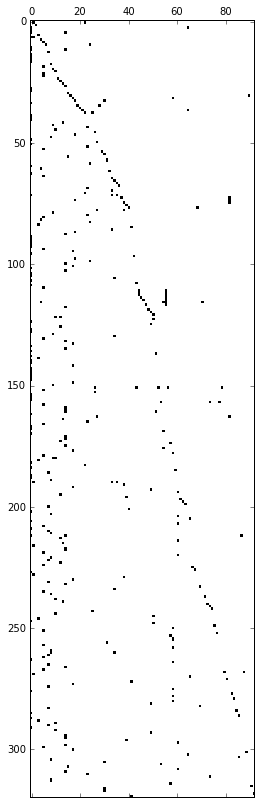

In [567]:
plt.matshow(1-myMatrix,
            cmap=plt.cm.gray, vmin=0, vmax=1)

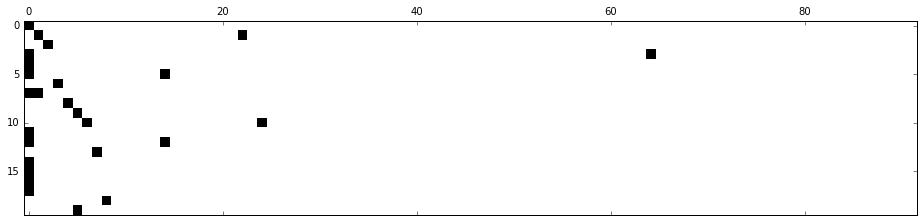

In [568]:
plt.matshow(1-myMatrix[0:20,:],
            cmap=plt.cm.gray, vmin=0, vmax=1)

So some of the **unique BankEntries** do indeed go to different accounts.

In [569]:
myMatrix[5,:]

array([ 9.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

## Testing the baseline classifier <a id='TestingTheBaselineClassifier'></a> 

In [570]:
# Divide the dataset into 80% train set and 20% test set
percentTrainSize = 0.8
trainSize = int(round(percentTrainSize*company_df.shape[0]))
testSize = int(company_df.shape[0]-trainSize)

train_df = company_df.head(trainSize)
test_df = company_df.tail(testSize)

# Build the matrice on the train set
trainMatrix = np.zeros((numUniqueBankEntries,numUniqueAccounts))
kk = 0
for bankEntry in BankEntryText:
    temp_df = train_df[train_df.BankEntryText == bankEntry]
    iteration = temp_df['AccountNumber']
    for item in iteration:
        accountIndex = AccountNumber == item
        trainMatrix[kk,:] = trainMatrix[kk,:] + accountIndex
    kk += 1
    
    

# Find the maximal element in the matrice and save a dictionary that contains BankEntry string and Account number
indices = np.zeros(len(trainMatrix))
for row in range(0,len(trainMatrix)):
    index = np.where(trainMatrix[row,:]==max(trainMatrix[row,:]))
    indices[row] = index[0][0]
    #trainMatrix[row,index][0][0]

# Making the dictionary
kk=0
bankEntryTextToAccountNumber = {}
for bankEntry in BankEntryText:
    bankEntryTextToAccountNumber[bankEntry] = AccountNumber[indices[kk]]
    kk += 1

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:33: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [571]:
y_test = np.zeros((testSize,1))
kk = 0
for account in test_df['AccountNumber']:
    y_test[kk] = account
    kk += 1
    
kk = 0
y_predict = np.zeros((testSize,1))
for text in test_df['BankEntryText']:
    y_predict[kk] = bankEntryTextToAccountNumber[text]
    kk += 1

numCorrect = float(sum(y_predict==y_test))
accuracy = numCorrect/testSize

print('Number of test cases is: ' + str(testSize))
print('number of correct predictions is: ' + str(numCorrect))
print('The accuracy is: ' + str(accuracy))


Number of test cases is: 162
number of correct predictions is: 96.0
The accuracy is: 0.592592592593


For a base line that isn't bad

# Running the classifier on each company

In [572]:
import baselineClassifier as bsclf
reload(bsclf)

allTestSizes = np.zeros((100,1))
allNumCorrect = np.zeros((100,1))
allAccuracies = np.zeros((100,1))
kk=0
for company in companies:
    company_df = data[data.CompanyId == company]
    testSize, numCorrect, accuracy = bsclf.baselineClassifier(company_df)
    
    allTestSizes[kk] = testSize
    allNumCorrect[kk] = numCorrect
    allAccuracies[kk] = accuracy
    
    kk += 1

The average accuracy is: [ 0.32940156]


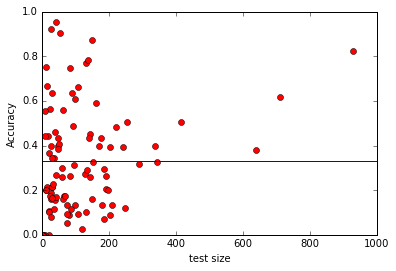

In [573]:
avgAccuracy = sum(allAccuracies)/len(allAccuracies)

plt.plot(allTestSizes,allAccuracies,'or')
plt.plot([0, 1000],[avgAccuracy, avgAccuracy],'-b')
plt.axis([0, 1000, 0, 1])
plt.xlabel('test size')
plt.ylabel('Accuracy')

print('The average accuracy is: ' + str(avgAccuracy))

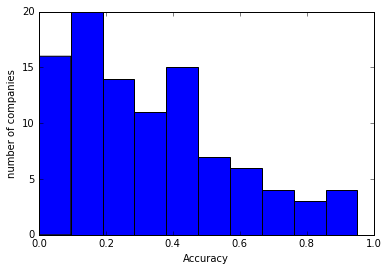

In [578]:
plt.hist(allAccuracies)
plt.ylabel('number of companies')
plt.xlabel('Accuracy')

### Summary of the baseline classifier

# The second part<a id='TheSecondPart'></a>
Making a classifier that can take advantage of data across different companies. The allows us to avoid the __cold start__ problem.

### Makking text onto features
One way to get around this is to build a classifier that is based on the name of the account name rather than the speficic account id. In this way, if a company open up a new account with a title that is allready known we would be able to use the information from other companies. 